In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
df = pd.read_excel("/kaggle/input/odir-5k-37-clases/odir-5k-37-clases.xlsx",engine="openpyxl")

df.head()



,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,branch retinal vein occlusion,cataract,central retinal vein occlusion,chorioretinal atrophy,diabetic retinopathy,...,retinal pigmentation,retinitis pigmentosa,severe nonproliferative retinopathy,severe proliferative diabetic retinopathy,spotted membranous change,suspected glaucoma,tessellated fundus,vitreous degeneration,wet age-related macular degeneration,white vessel
0,1,69,Female,0_right.jpg,normal fundus,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,57,Male,1_right.jpg,normal fundus,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print( df.columns[5:])
abreviaturas = [
    "BRARETVEIOCC",         # branch retinal vein occlusion
    "CATAR",    # Cataract
    "CENRETVEIOCC",    # central retinal vein occlusion
    "CARAT",    # Chorioretinal Atrophy
    "DIARET",       # Diabetic Retinopathy
    "DRUS",     # Drusen
    "DRAGMADE",   # Dry Age-Related Macular Degeneration
    "EPME",     # Epiretinal Membrane
    "EPMOM",    # Epiretinal Membrane over the Macula
    "GLAU",     # Glaucoma
    "HYPRE",    # Hypertensive Retinopathy
    "LASER",       # Laser Spot
    "LEDU",       # Lens Dust
    "MAEPME",      # Macular Epiretinal Membrane
    "MACULO",   # Maculopathy
    "MINORE",     # Mild Nonproliferative Retinopathy
    "MONOPRRE",   # Moderate Non Proliferative Retinopathy
    "MYEL",      # Myelinated Nerve Fibers
    "MYOP",     # Myopia Retinopathy
    "NORMFUND", # normal fundus
    "OPTDISEDE",      # Optic Disc Edema
    "PAMY",       # Pathological Myopia
    "PERIATRO",       # Peripapillary Atrophy
    "POSLASPHO",      # Post Laser Photocoagulation
    "PORELASU",     # Post Retinal Laser Surgery
    "PRODIRE",      # Proliferative Diabetic Retinopathy
    "REFMEOP",      # Refractive Media Opacity
    "RETINALPIG",       # Retinal Pigmentation
    "RETINIPIG",       # Retinitis Pigmentosa
    "SENORE",     # Severe Nonproliferative Retinopathy
    "SEPRODIRE",    # Severe Proliferative Diabetic Retinopathy
    "SPOMEMCHA",      # Spotted Membranous Change
    "SUSPGLAU",       # Suspected Glaucoma
    "TESSEFUN",       # Tessellated Fundus
    "VITDE",       # Vitreous Degeneration
    "WETAMD",   # Wet Age-Related Macular Degeneration
    "WHVES"        # White Vessel
]

print(len(abreviaturas))
print(len(df.columns[5:]))


Index(['branch retinal vein occlusion', 'cataract',
       'central retinal vein occlusion', 'chorioretinal atrophy',
       'diabetic retinopathy', 'drusen',
       'dry age-related macular degeneration', 'epiretinal membrane',
       'epiretinal membrane over the macula', 'glaucoma',
       'hypertensive retinopathy', 'laser spot', 'lens dust',
       'macular epiretinal membrane', 'maculopathy',
       'mild nonproliferative retinopathy',
       'moderate non proliferative retinopathy', 'myelinated nerve fibers',
       'myopia retinopathy', 'normal fundus', 'optic disc edema',
       'pathological myopia', 'peripapillary atrophy',
       'post laser photocoagulation', 'post retinal laser surgery',
       'proliferative diabetic retinopathy', 'refractive media opacity',
       'retinal pigmentation', 'retinitis pigmentosa',
       'severe nonproliferative retinopathy',
       'severe proliferative diabetic retinopathy',
       'spotted membranous change', 'suspected glaucoma', 'tess

# Creating Dataset from images

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import random
from tqdm import tqdm

dataset_dir = "/kaggle/input/myodir-5k-crop/myodir-crop"
image_size = 224
label_columns = df.columns[5:]

def create_dataset(df, image_column, label_columns, image_size, remove_class_15_count=200, remove_class_16_count=650, remove_class_19_count=2720):
    dataset = []
    class_16_removed = 0
    class_15_removed = 0
    class_19_removed = 0
    datagen = ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20, 
                                 fill_mode='constant',
                                 cval=0.
                                 )

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing images'):
        image_path = os.path.join(dataset_dir, row[image_column])
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  # Normalize pixel values

            label_edema = row[label_columns].values

            # Check if the image belongs to class 8 and if we need to skip it
            if label_edema[15] == 1 and class_15_removed < remove_class_15_count:
                class_15_removed += 1
                continue
            if label_edema[16] == 1 and class_16_removed < remove_class_16_count:
                class_16_removed += 1
                continue
            if label_edema[19] == 1 and class_19_removed < remove_class_19_count:
                class_19_removed += 1
                continue

            augmented_image = datagen.random_transform(image)
            dataset.append([np.array(augmented_image), label_edema])
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue

    random.shuffle(dataset)
    return dataset

dataset = create_dataset(df, "Fundus", label_columns, 224)


Processing images: 100%|██████████| 6799/6799 [05:53<00:00, 19.22it/s]


In [5]:
print(abreviaturas)

['BRARETVEIOCC', 'CATAR', 'CENRETVEIOCC', 'CARAT', 'DIARET', 'DRUS', 'DRAGMADE', 'EPME', 'EPMOM', 'GLAU', 'HYPRE', 'LASER', 'LEDU', 'MAEPME', 'MACULO', 'MINORE', 'MONOPRRE', 'MYEL', 'MYOP', 'NORMFUND', 'OPTDISEDE', 'PAMY', 'PERIATRO', 'POSLASPHO', 'PORELASU', 'PRODIRE', 'REFMEOP', 'RETINALPIG', 'RETINIPIG', 'SENORE', 'SEPRODIRE', 'SPOMEMCHA', 'SUSPGLAU', 'TESSEFUN', 'VITDE', 'WETAMD', 'WHVES']


LASER


<Figure size 2000x1000 with 0 Axes>

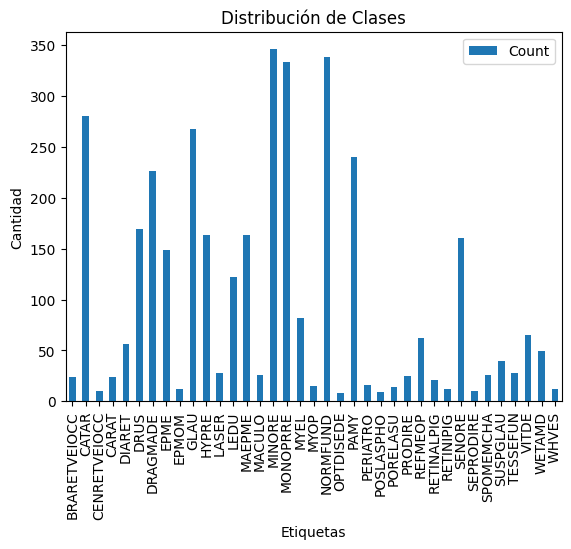

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer las etiquetas del conjunto de datos
labels_from_dataset = np.array([item[1] for item in dataset])

# Inicializar un diccionario para contar las frecuencias
class_counts = {label: 0 for label in abreviaturas}
print(abreviaturas[11])
# Contar la frecuencia de cada etiqueta
for labels in labels_from_dataset:
    for i, label in enumerate(abreviaturas):
        class_counts[label] += labels[i]

# Crear un DataFrame para los recuentos
counts_df = pd.DataFrame(list(class_counts.items()), columns=['Label', 'Count']).set_index('Label')

# Crear la gráfica de barras
plt.figure(figsize=(20, 10))
counts_df.plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.show()



# Dividing dataset into x(features) & y(target)

In [7]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

Train Test Split (80/20)

In [8]:
from sklearn.model_selection import train_test_split

# Supongamos que x e y son tus datos y etiquetas
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [9]:
print(len(y_train_val))
print(len(y_test))

2583
646


# Creating Model

In [10]:
"""import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet  import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.densenet  import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

densenet = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
#build a model with a densenet layers
def model_build():
    model = tf.keras.Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(37, activation='sigmoid'))

    return model


for layer in densenet.layers:
    layer.trainable = False

# Luego, congelar las últimas 5 capas
for layer in densenet.layers[-32:]:
    layer.trainable = True


model = model_build()
"""


"import tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import DenseNet121\nfrom tensorflow.keras.applications.vgg16 import VGG16\nfrom tensorflow.keras.applications.vgg19 import VGG19\nfrom tensorflow.keras.applications.inception_v3 import InceptionV3\nfrom tensorflow.keras.applications.xception import Xception\nfrom tensorflow.keras.applications.efficientnet  import EfficientNetB0\nfrom tensorflow.keras.applications.resnet import ResNet152\nfrom tensorflow.keras.applications.nasnet import NASNetLarge\nfrom tensorflow.keras.applications.densenet  import DenseNet201\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.optimizers import Adam\n\ndensenet = InceptionV3(\n    weights='imagenet',\n    include_top=False,\n    input_shape=(224,224,3)\n)\n#build a model with a densenet layers\ndef model_build():\n    model = tf.keras.Sequential()\n    model.add(densene

In [11]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet  import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.densenet  import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
model = tf.keras.models.Sequential([
      # The first convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.BatchNormalization(),
      # The second convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      # The fourth convolution
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
     
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(37, activation='sigmoid')
  ])


2024-01-20 06:04:46.461522: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.461650: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.461733: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.461812: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.461887: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.462095: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-20 06:04:46.462203: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_val, y_train_val)):
    print(f"Training on fold {fold+1}/{n_splits}")

    # Dividir los datos
    x_train_fold, y_train_fold = x[train_idx], y[train_idx]
    x_val_fold, y_val_fold = x[val_idx], y[val_idx]
    x_train_fold, y_train_fold = x[train_idx], y[train_idx]
    x_val_fold, y_val_fold = x[val_idx], y[val_idx]
    x_train_fold = x_train_fold.astype('float32')
    y_train_fold = y_train_fold.astype('float32')
    x_val_fold = x_val_fold.astype('float32')
    y_val_fold = y_val_fold.astype('float32')
    




    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Entrenar el modelo
    history = model.fit(
        x_train_fold, y_train_fold, 
        batch_size=8, 
        epochs=20, 
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
      # Asegúrate de que cls_wt_dict esté definido apropiadamente
    )

    # Aquí puedes guardar el modelo o los resultados de cada fold si lo deseas


Training on fold 1/5


Epoch 1/20
259/259 [==============================] - 108s 405ms/step - loss: 0.4133 - binary_accuracy: 0.8659 - val_loss: 0.1440 - val_binary_accuracy: 0.9697 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 99s 382ms/step - loss: 0.1248 - binary_accuracy: 0.9694 - val_loss: 0.2380 - val_binary_accuracy: 0.9582 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 98s 377ms/step - loss: 0.1179 - binary_accuracy: 0.9694 - val_loss: 0.5195 - val_binary_accuracy: 0.9370 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 97s 376ms/step - loss: 0.1154 - binary_accuracy: 0.9696 - val_loss: 0.1169 - val_binary_accuracy: 0.9684 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 96s 370ms/step - loss: 0.1143 - binary_accuracy: 0.9699 - val_loss: 0.1170 - val_binary_accuracy: 0.9684 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 93s 359ms/step - loss: 0.1120 - binary_accuracy: 0.9701 - val_loss: 0.1253 - val_bina

Epoch 1/20
259/259 [==============================] - 101s 380ms/step - loss: 0.0853 - binary_accuracy: 0.9735 - val_loss: 0.1567 - val_binary_accuracy: 0.9634 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 100s 387ms/step - loss: 0.0712 - binary_accuracy: 0.9764 - val_loss: 0.0774 - val_binary_accuracy: 0.9741 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 100s 384ms/step - loss: 0.0590 - binary_accuracy: 0.9794 - val_loss: 0.1466 - val_binary_accuracy: 0.9739 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 99s 382ms/step - loss: 0.0496 - binary_accuracy: 0.9827 - val_loss: 0.0818 - val_binary_accuracy: 0.9744 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 99s 383ms/step - loss: 0.0336 - binary_accuracy: 0.9891 - val_loss: 0.0865 - val_binary_accuracy: 0.9737 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 100s 386ms/step - loss: 0.0241 - binary_accuracy: 0.9926 - val_loss: 0.1003 - val_b

In [ ]:
print(history.history)

In [ ]:
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
loss, accuracy = model.evaluate(x_test, y_test)
print("loss:", loss)
print("Accuracy:", accuracy)


In [ ]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)

plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Hacer predicciones
y_pred_probs = model.predict(x_test)

threshold = 0.5
y_pred_classes = (y_pred_probs > threshold).astype(int)

# Asumiendo que y_test ya es un array binario multietiqueta
y_true_classes = y_test
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    categories = y_true_classes[sample]
    pred_categories = y_pred_classes[sample]
    
    # Obtener etiquetas y predicciones como listas de nombres de categorías
    labels = [abreviaturas[j] for j in range(len(categories)) if categories[j] == 1]
    pred_labels = [abreviaturas[j] for j in range(len(pred_categories)) if pred_categories[j] == 1]
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(', '.join(labels), ', '.join(pred_labels)))
plt.tight_layout()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd


prediction_test = model.predict(x_test)



prediction_test_rounded = (prediction_test > 0.5).astype(int)


# Configura el parámetro zero_division en precision_score y f1_score
zero_division = 1


# Calcula las métricas para prueba
precision_test = precision_score(y_test, prediction_test_rounded, average='samples', zero_division=zero_division)
recall_test = recall_score(y_test, prediction_test_rounded, average='samples')
f1_test = f1_score(y_test, prediction_test_rounded, average='samples', zero_division=zero_division)



# Añade los resultados a tu DataFrame
evaluation = pd.DataFrame({
    'Model': ['Neural Network'],
   
    'Precision(test)': [precision_test],
    'Recall(test)': [recall_test],
    'F1_score(test)': [f1_test],
   
})

print(evaluation)

In [ ]:
model.save("model_13_clases_best.h5")

In [ ]:
y_pred_classes

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que y_true y y_pred son tus etiquetas reales y predichas respectivamente
# y_true y y_pred deben ser de forma (n_muestras, n_etiquetas)

for i, label in enumerate(label_columns):
    # Calcular la matriz de confusión para cada etiqueta
    cm = confusion_matrix(y_true_classes[:, i], y_pred_classes[:, i])

    # Configuración de colores y estilo para asegurar visibilidad al descargar
    plt.figure(figsize=(10,7))
    sns.set(style="white")  # Establece un estilo de fondo claro
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Matriz de Confusión para la etiqueta: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Guardar la figura con un fondo que asegure visibilidad
    plt.savefig(f"confusion_matrix_{label}.png", bbox_inches='tight', transparent=False)
    plt.close()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Calcula la curva ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 37

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualizar las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC for multi-class')
plt.legend(loc="lower right")
plt.show()
